# Импорт данных и библиотек


In [1]:
#@title
# Импорт предварительно обработанного файла данных
!gdown --id 10wt0mzewDlgYS14QOB2jBhNYTuec6ai_

import pandas as pd
import matplotlib.colors as mcolors
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

ds = pd.read_excel('grouped_set.xlsx')

"gdown" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


ModuleNotFoundError: No module named 'pandas'

In [2]:
#@title
# иництализируем шрифты
params = {
          'axes.titlesize': 15,   
          'xtick.labelsize': 12,  
          'axes.labelsize': 14    
          }
plt.rcParams.update(params)

Файл **grouped_set** сожержит отобранные  из основного датасета вакансии, которым добавлено дополнительное поле spec - содержащее объединенные вакансии, схожие по смыслу, но, возможно, содержащие разные названия вакансии.
Фильтрация вакансий проводилась в ручную в блокноте: https://colab.research.google.com/drive/1c4fPxM7kwloxkCVKS2uJOZ9PdYJ7PhYE#scrollTo=XvC7uikEGFaU 

# Предварительный анализ и подготовка датасета
* Пропуски
* Битые и некорректные данные
* Конвертация элементов

Предварительно для анализа были отобраны следующие столбцы исходного датасета:

In [3]:
#@title
cols = ds.columns
for i in range(1, len(cols)):
  print(cols[i], end='; ')

name; spec; salary; experience; key_skills; specializations; working_time_modes; schedule; snippet; employer; 

Посмотрим, что содержит наш датасет:

In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31201 entries, 0 to 31200
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          31201 non-null  int64 
 1   name                31201 non-null  object
 2   spec                31201 non-null  object
 3   salary              13814 non-null  object
 4   experience          31201 non-null  object
 5   key_skills          31200 non-null  object
 6   specializations     31201 non-null  object
 7   working_time_modes  31201 non-null  object
 8   schedule            31200 non-null  object
 9   snippet             31201 non-null  object
 10  employer            31201 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.6+ MB


В столбце salary содержащем информацию об оплате содержится много пропусков, а также этот столбец имеет тип строка.
Займемся решением этих проблем.
Для начала выясним, что вообще содержится в столбце salary

In [5]:
ds.salary.unique()

array([nan,
       "{'from': 55000, 'to': None, 'currency': 'RUR', 'gross': True}",
       "{'from': 200000, 'to': 220000, 'currency': 'RUR', 'gross': False}",
       ...,
       "{'from': 62000, 'to': 62000, 'currency': 'RUR', 'gross': False}",
       "{'from': 2500, 'to': 4000, 'currency': 'USD', 'gross': True}",
       "{'from': 40, 'to': 55000, 'currency': 'RUR', 'gross': True}"],
      dtype=object)

Видим, что задается в общем случае зарплатная вилка с указанием типа валюты. Поробуем посмотреть что за валюты тут встречаются:


In [6]:
#@title
def get_curr(s):
  if isinstance(s, str):
      try:
        return re.search('currency.{10}',s).group()
      except:
        return s  
  else:
    return s
curr = ds.salary.apply(get_curr)
curr.unique()

array([nan, "currency': 'RUR', ", "currency': 'USD', ",
       "currency': 'EUR', ",
       "{'id': '2', 'name': 'Санкт-Петербург', 'url': 'https://api.hh.ru/areas/2'}"],
      dtype=object)

Итак, в датасете 3 вида валют - RUR EUR USD и какие то поломаные строки содержащие некорректную информацию.


Итак
1. удалим битые значения
2. заменим все пропуски нулями
3. сконвертируем все строки в целое, заодно конвертируя доллары и евро в рубли, и отбрасывая предположительно неверно указанные данные(с очевидно неверной зп)

In [7]:
#@title
ds.salary = ds.salary.apply(lambda x: 0 if 'Санкт-Петербург' in str(x) else x)  #  1. удаляем строки с Санкт-Петербург а категории зп 
ds.salary = ds.salary.fillna(0)    # 2. заменим нонтайп значения нулями

# 3. Функция конвертации - ratios словарь с курсом для каждой валюты деленный на 2, чтобы не делить каждый раз при поиске серднего
def converter(s):
  ratios = {'USD': 30, 'EUR': 30, 'RUR': 0.5}
  if isinstance(s, str):
    lst = re.findall(r'\d{1,}', str(s)) # находим числа в строке и помещаем в список
    
    payment = int(int(lst[0])+int(lst[-1])) # находим сумму зарплатной вилки, если указано 1 значение, оно используется оба раза
    ratio = ratios[re.search(r"(?<=currency': ')\w{3}", s).group()] # вытягиваем из строки название валюты и по ключу получаем курс из словаря
    return payment*ratio
  else:
    return s # для нулей

ds.salary =  ds.salary.apply(converter) # конвертируем зп в число  рублей
ds = ds[ds['salary'].apply(lambda x: x > 15000)] # удаляем 0 и выбросы


Займемся столбцом, содержащим информацию об опыте работы

In [8]:
ds.experience.unique()

array(["{'id': 'between1And3', 'name': 'От 1 года до 3 лет'}",
       "{'id': 'between3And6', 'name': 'От 3 до 6 лет'}",
       "{'id': 'noExperience', 'name': 'Нет опыта'}",
       "{'id': 'moreThan6', 'name': 'Более 6 лет'}",
       '</li> <li>Понимание работы РБД', 'Бафус&quot',
       '</li> <li>Доработка интеграции на основе готовых решений.</li> </ul> <strong>Требования:</strong> <ul> <li>Глубокое знание архитектуры 1С',
       'НПО&quot',
       '</li> <li>модификация и обновления существующих документов и отчетов',
       '</li> <li>Подготовка к сдаче экзаменов на сертификаты 1С за счет организации',
       '</li> <li>Опыт управления людьми и небольшими проектами</li> </ul> <p><strong>Обязанности:</strong></p> <ul> <li>Выполнение задач по автоматизации различных участков компании в 1с. </li> <li>Формирование идеологии автоматизации учета в компании.</li> <li>Контроль сторонних разработчиков. Тестирование и приемка работ</li> </ul>',
       '</li> <li>Разработка и развитие метод

Итак, "правильные" данные содержат подстроки:

between1And3, between3And6, noExperience, moreThan6
А также ряд строк содержит информацию о требованиях к опыту соискателя.
Сконвертируем столюец в численные значения, указав там минимальный опыт:
* 0 - опыт не требуется
* 1 - от 1 до 3 лет
* 3 - от 3 до 6 лет
* 6 - более 6 лет
Неверно заполненным значениям положим требуемый опыт - 1, так как какой-то опыт там все же(видимо) требуется.


In [9]:
#@title
exp = {'noExperience': 0, 'between1And3': 1, 'between3And6': 3, 'moreThan6': 6}

def exp_in_numbers(s):
  for i in exp.keys():
    if i in s:
      return exp[i]
      break
  else:
    return 1
ds.experience = ds.experience.apply(exp_in_numbers)       
ds.experience.unique() 

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


array([1, 3, 0, 6])

Посмотрим содержимое key_skills и snippet

In [10]:
ds[['key_skills', 'snippet']]

,key_skills,snippet
10,"[{'name': 'Тестирование'}, {'name': 'Проведени...",{'requirement': 'Навыки ручного тестирования в...
12,"[{'name': 'ручное тестирование'}, {'name': 'QA...",{'requirement': 'Опыт от 3х лет в тестировании...
18,"[{'name': 'postman'}, {'name': 'SOAP UI'}, {'n...",{'requirement': 'Опыт работы тестировщиком - о...
21,"[{'name': 'Atlassian Jira'}, {'name': 'Функцио...",{'requirement': 'Знание методологий тестирован...
24,"[{'name': 'Тестирование'}, {'name': 'Регресcио...",{'requirement': 'Внимательны и наблюдательны. ...
...,...,...
31185,"[{'name': 'Управление проектами'}, {'name': 'О...",{'requirement': 'Опыт управления проектами в о...
31186,"[{'name': 'Навыки презентации'}, {'name': 'Про...",{'requirement': 'Опыт работы project-менеджеро...
31187,"[{'name': 'Управление проектами'}, {'name': 'Р...",{'requirement': 'Можешь показать свои кейсы. И...
31189,[],{'requirement': 'Знание и понимание основ Битр...


key_skills - конкрентные ключевые навыки, хардскилы, требуемые от соискателю
snippet - более общие требования к его компетенциям
На данном этапе ограничимся анализом требуемых хардскилов из столбца key_skills
сконвертируем key_skills в более удобный для работы формат - строку содержащую хардскилы через запятую. 
 

In [11]:
#@title
def extract_key_skills(s):
  regexp = r"(?<='name': ').*?(?=\')"
  try:
    l = re.findall(regexp, s)
    s = ','.join(l).lower() 
  finally:
    return s  
    
ds.key_skills = ds.key_skills.apply(extract_key_skills)

In [12]:
#@title
# Устраним ошибки в категориях, допущенные в предварительной выборке профессий:
ds.spec = ds.spec.apply(lambda x: 'Специалист по тестированию' if x == 'Специалист по ручному тестированию' else x)
ds.spec = ds.spec.apply(lambda x: '1C разработчик' if x == '1c разработчик' else x)
ds.spec = ds.spec.apply(lambda x: 'frontend developer' if x == 'web разработчик' else x)
ds.spec = ds.spec.apply(lambda x: 'bsckend developer' if x == 'Программист' else x)
ds.spec = ds.spec.apply(lambda x: '1C разработчик' if x == '1C аналитик' else x)


In [13]:
#@title
#подключим файл с синонимами для скилов. который был сгенерирован ниже и отредактирован 
!gdown --id 1cpD43H_xkFQTiEY6YKMplA_nfByR5OB7 
skills_ = pd.read_excel('skills.xlsx')
skills_.fillna(0)
skills_dict ={}
for i in skills_.itertuples():
  skills_dict[i[1]] = i[2]
skills_dict  

def new_skills(s):
  lst = []
  for i in s.split(','):
    try:
      if skills_dict[i] != 0:
       lst.append(skills_dict[i])
      else:
        lst.append(i) 
    except:   
      pass        
  for i in range(len(lst)):
    lst[i] = str(lst[i])

  return ','.join(lst) 

ds.key_skills = ds.key_skills.apply(new_skills)     

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1cpD43H_xkFQTiEY6YKMplA_nfByR5OB7
To: /content/skills.xlsx
100% 28.6k/28.6k [00:00<00:00, 37.5MB/s]


Поработаем с колонкой специализация - specializations
удалим неотфильтровнные ранее вакансии, не относящиеся к IT:

In [ ]:
ds.specializations.unique()


Вытащим содержимое ключа name и поместим его в поле

In [26]:
#@title
f_spec = ds.specializations.apply(lambda x: 'Информационные технологии, интернет, телеком' in x)
ds = ds[f_spec]
ds.specializations = ds.specializations.apply(extract_key_skills

,Unnamed: 0,name,spec,salary,experience,key_skills,specializations,working_time_modes,schedule,snippet,employer
10,10,Тестировщик ПО/ QA engineer (ручное тестирование),Специалист по тестированию,55000.0,1,"тестирование по,ручное тестирование,linux,mac ...",тестирование,[],"{'id': 'remote', 'name': 'Удаленная работа'}",{'requirement': 'Навыки ручного тестирования в...,"{'id': '52582', 'name': 'Смартек', 'url': 'htt..."
12,12,Тестировщик/QA engineer Senior (ручной),Специалист по тестированию,210000.0,3,"ручное тестирование,автоматизированное тестиро...","программирование, разработка,инженер,тестирование",[],"{'id': 'remote', 'name': 'Удаленная работа'}",{'requirement': 'Опыт от 3х лет в тестировании...,"{'id': '701365', 'name': 'Бизнес-Азимут', 'url..."
18,18,Тестировщик ручной/QA engineer manual,Специалист по тестированию,175000.0,3,"postman,soap,sql,ручное тестирование,функциона...","программирование, разработка,инженер,тестирование",[],"{'id': 'remote', 'name': 'Удаленная работа'}",{'requirement': 'Опыт работы тестировщиком - о...,"{'id': '701365', 'name': 'Бизнес-Азимут', 'url..."
21,21,"QA Middle/Тестировщик (Ручное тестирование), у...",Специалист по тестированию,210000.0,1,"atlassian jira,функциональное тестирование,atl...","программирование, разработка,инженер,тестирование",[],"{'id': 'remote', 'name': 'Удаленная работа'}",{'requirement': 'Знание методологий тестирован...,"{'id': '1613682', 'name': 'Soft Jet', 'url': '..."
24,24,Младший специалист ручного тестирования mini app,Специалист по тестированию,99999.0,0,"тестирование по,регрессионное тестирование,фун...","программирование, разработка,инженер,тестирование",[],"{'id': 'fullDay', 'name': 'Полный день'}",{'requirement': 'Внимательны и наблюдательны. ...,"{'id': '6002908', 'name': 'Интеграционная реги..."
...,...,...,...,...,...,...,...,...,...,...,...
31185,31185,Проджект-менеджер/Project-менеджер в онлайн шк...,Project manager,150000.0,3,"управление проектами,проектный менеджмент,анал...","менеджмент продукта (product manager),управлен...",[],"{'id': 'fullDay', 'name': 'Полный день'}",{'requirement': 'Опыт управления проектами в о...,"{'id': '5613444', 'name': 'Онлайн школа Саши Б..."
31186,31186,Project-менеджер,Project manager,65000.0,1,"ручное тестирование,грамотная устная и письмен...","программирование, разработка,системы управлени...",[],"{'id': 'fullDay', 'name': 'Полный день'}",{'requirement': 'Опыт работы project-менеджеро...,"{'id': '4240536', 'name': 'Студия ИСКРА', 'url..."
31187,31187,Project-менеджер в IT,Project manager,27520.0,1,"управление проектами,умение работать в команде...","менеджмент продукта (product manager),управлен...",[],"{'id': 'fullDay', 'name': 'Полный день'}",{'requirement': 'Можешь показать свои кейсы. И...,"{'id': '5310809', 'name': 'Avocado Digital', '..."
31189,31189,Project менеджер,Project manager,50000.0,1,,"программирование, разработка,системы управлени...",[],"{'id': 'fullDay', 'name': 'Полный день'}",{'requirement': 'Знание и понимание основ Битр...,"{'id': '990932', 'name': 'Dial', 'url': 'https..."


# Анализ численных данных

###Посмотрим статистику по зарплатам и опыту:


In [36]:
#@title
print(f' min {ds.salary.min()}, max {ds.salary.max()}, среднее {int(ds.salary.mean())}, медиана {int(ds.salary.median())}')
print(f'процентиль - мера, показывающая, какое количество значений в датасете равен или меньше ее')
print(f'75 прцентиль - 3 квартиль {int(ds.salary.quantile(0.75))}')
print(f'50 прцентиль - 2 квартиль {int(ds.salary.quantile(0.5))}')
print(f'25 прцентиль - 1 квартиль {int(ds.salary.quantile(0.25))}')
print(f'99 прцентиль  {int(ds.salary.quantile(0.99))}')
ds.salary.describe()

 min 15494.0, max 840000.0, среднее 110983, медиана 90000
процентиль - мера, показывающая, какое количество значений в датасете равен или меньше ее
75 прцентиль - 3 квартиль 150000
50 прцентиль - 2 квартиль 90000
25 прцентиль - 1 квартиль 53000
99 прцентиль  360000


count     13509.000000
mean     110983.448072
std       77890.689039
min       15494.000000
25%       53000.000000
50%       90000.000000
75%      150000.000000
max      840000.000000
Name: salary, dtype: float64

In [37]:
ds.experience.describe()

count    13509.000000
mean         1.643941
std          1.264108
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max          6.000000
Name: experience, dtype: float64

Средняя зарплата в отрасли - 110 000, медианная  - 90 000
В среднем требования по опыту чуть выше чем 1-3 годв
Более подробно увидим это на графиках

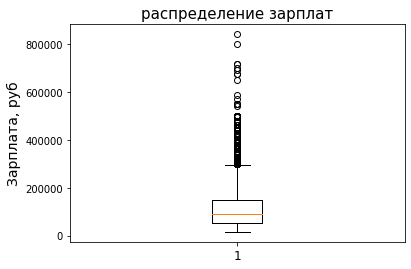

In [38]:
#@title
plt.boxplot(ds.salary)
plt.title('распределение зарплат')
plt.ylabel('Зарплата, руб')
plt.show()

Основная масса вакансий предлагает заработную плату от 50000р до 150000р Зарплаты до 300000р в отрасли - это в принципе реально, свыше 350000р - скорее исключение. Более наглядно объем предлагаемых вакансий с распределением по зароботной плате видно на графике ниже.

Text(0, 0.5, 'Число вакансий')

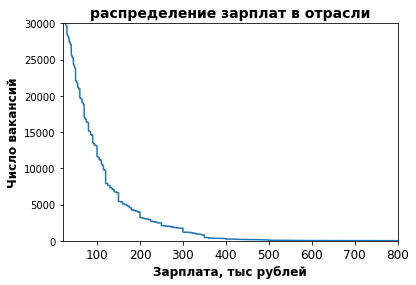

In [39]:
#@title
plt.plot(ds.salary.sort_values(ascending=False)/1000, ds.salary.index)
plt.xlim(20, 800)
plt.ylim(0,30000)

plt.title('распределение зарплат в отрасли', fontsize=14, fontweight='bold')
plt.xlabel('Зарплата, тыс рублей', fontsize=12, fontweight='bold')
plt.ylabel('Число вакансий', fontsize=12, fontweight='bold')

## Посмотрим, на распределение количества вакансий относительно требуемого опыта

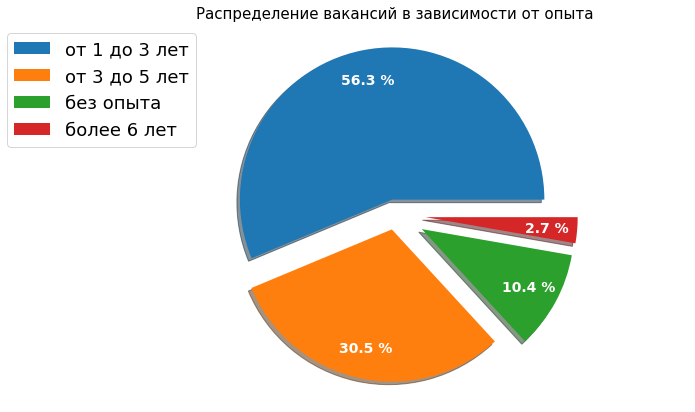

In [40]:
#@title
exp_val = ds['experience'].value_counts()
labels = ['от 1 до 3 лет', 'от 3 до 5 лет', 'без опыта', 'более 6 лет']
fig = plt.figure(figsize=(15, 7))
percent = r'%'
exp = (0.1, 0.1, 0.2, 0.2)
ax = fig.add_subplot()
ax.pie(exp_val, labels=labels, explode=exp, shadow=True, pctdistance=0.8, autopct='%.1f %'+percent, textprops = dict(color='w', fontsize=14, fontweight='bold'))
ax.legend(bbox_to_anchor=(0,1), fontsize=18)
ax.set_title('Распределение вакансий в зависимости от опыта')

plt.show()

Итак более половины вакансий требуют от соискателя наличие опыта от 1 года. Еще почти треть вакансий требуют наличие опыта от трех лет и более.

# Анализ категориальных данных

## Посмотрим распределение вакансий на рынке труда

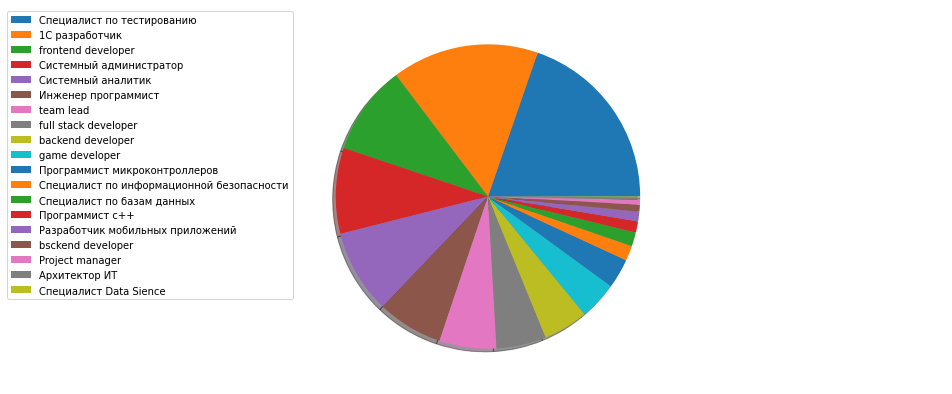

In [27]:
#@title
specs = ds['spec'].value_counts()
specs.index
specs.values

labels = ds['spec'].unique()

colors = dict(zip(labels, plt.cm.tab20.colors[:len(labels)]))
fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot()

ax.pie(specs, labels=labels,  shadow=True, textprops = dict(color='w'))
ax.legend(bbox_to_anchor=(0,1))
plt.show()

Из диаграммы выше мы видим, что сейчас большой спрос на специалистов в области 1с, web разработке, тестированию и системных администарторов и аналитиков. Эти специальности составляют более половины того, что требуется рынку.

## Теперь изучим ключевые навыки, требуемые работодателем от соискателей
Это то, что должен, знать/уметь соискатель для успешного трудоустройства.

Подсчитаем количество уникальных навыков:

In [ ]:
#@title

import operator
# посчитаем уникальные ключевые навыки:
key_skills = {}
k_s = {}
for k in ds.key_skills.values:
  if not isinstance(k,str):
    k=''
  for skill in k.split(','):
    key_skills[skill] = key_skills.setdefault(skill, 0)+1
counter = 0    
for i in key_skills:
  if key_skills[i] >= 20:
    k_s[i] = key_skills[i]
s_t = sorted(k_s.items(), key=operator.itemgetter(1), reverse=True)
key_skills = {k: v for k, v in s_t}
key_skills.pop('')
key_skills

Сохраним ключевые скилы в файл и выберем совпадающие(или почти совпадающие) навыки и объединим их в 1.
также удалим часть софт скилов, которым вряд ли удастся обучить на курсах. Делать все это придется вручную


In [48]:
#@title
skills_set = pd.DataFrame.from_dict(key_skills, orient='index').rename(columns={0:'Qunatity'})
skills_set.info()


<class 'pandas.core.frame.DataFrame'>
Index: 298 entries, 1с программирование to планирование продаж
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Qunatity  298 non-null    int64
dtypes: int64(1)
memory usage: 4.7+ KB


## Посмотрим топ 50 навыков среди всех профессий

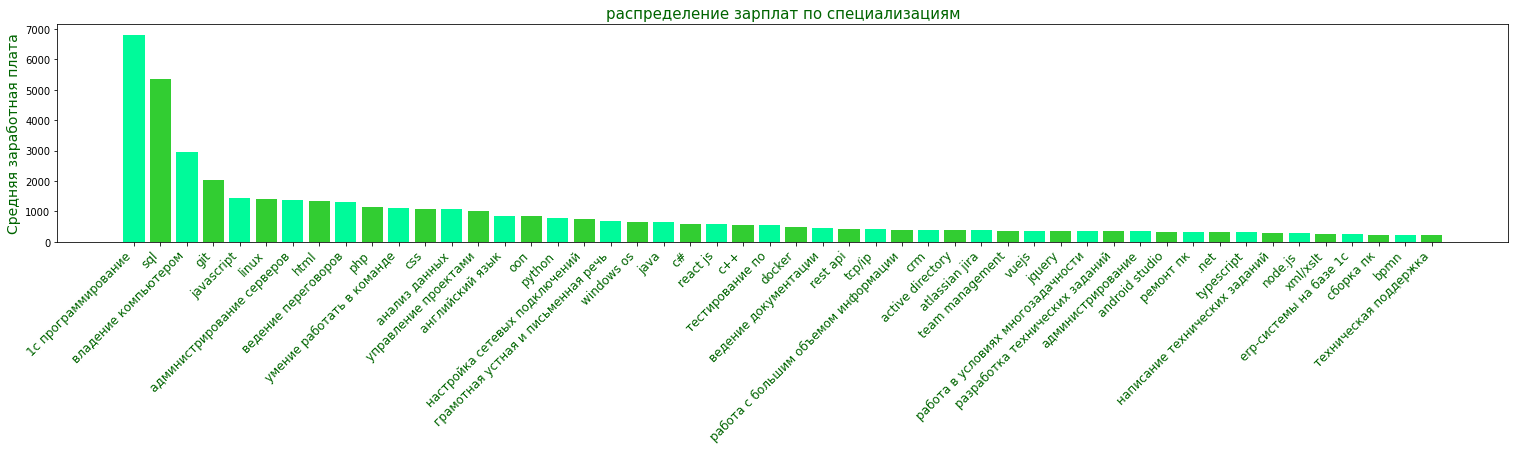

In [61]:
#@title
plt.figure(figsize=(26,4))
s_new = skills_set.iloc[:50]
plt.title('распределение зарплат по специализациям', color='darkgreen')
plt.ylabel('Средняя заработная плата', color='darkgreen')
plt.xticks(rotation=45,ha = 'right', color='darkgreen')
plt.bar(s_new.index, s_new.Qunatity, color=['mediumspringgreen','limegreen'])

plt.show()

Итак, помимо очевидного требования к 1с разработчикам умения работать с 1с и ко всем ИТ специалистам - владения компьютером, ожидаемо высокие места занимают навыки, необходимые практически каждому специалисту в этой области:

* работа с базами данных 
* знание систем контроля версий
* наличие навыков командной работы
* знания иностранного языка
* понимание объектно ориентированного программирования
* знание linux

A также ключевые навыки, относящиеся к какой то одной специализации:

* 1С разработка
* java script
* администрирование серверов
* PHP
* CSS\HTML
* Python
* Java

# Анализ взаимосвязей в данных

**Сопоставим зарплаты с профессией и требуемым опытом**

Большого разброса зарплат, в зависимости от специализации нет, видим, что системные администраторы и специалисты по информационной безопасности получают в с реднем меньше чем средняя зарплата в сфере IT, специалисты в Data Sience и IT Архитекторы - несколько больше рынка. Но это скорее связано с более высокими или наоборот более низкими требованиями к уровню компетенций.

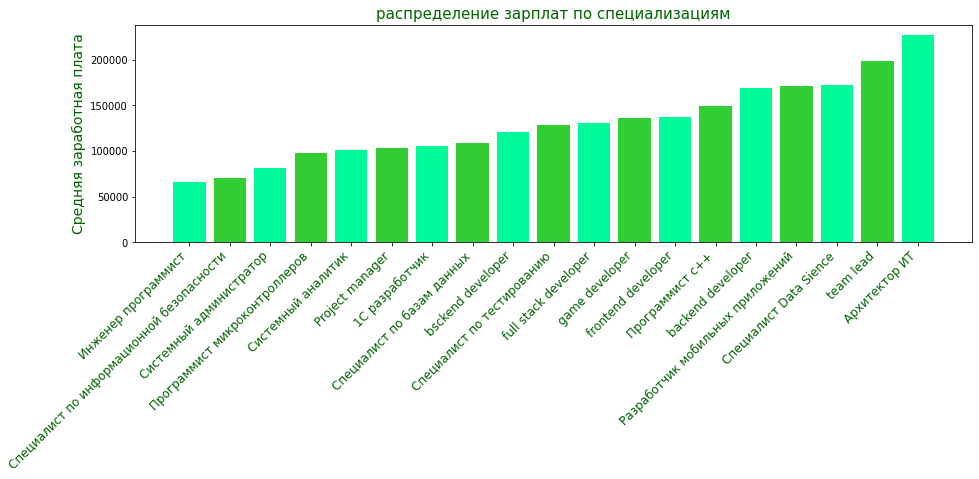

In [62]:
#@title
groups = ds.groupby('spec')
groups_sl = groups['salary']
groups_me = groups_sl.mean().astype(int)
groups_me = groups_me.sort_values()
plt.figure(figsize=(15,4))

plt.title('распределение зарплат по специализациям', color='darkgreen')
plt.ylabel('Средняя заработная плата', color='darkgreen')
plt.xticks(rotation=45,ha = 'right', color='darkgreen')
plt.bar(groups_me.index, groups_me, color=['mediumspringgreen','limegreen'])

plt.show()

**Зарплаты и опыт**

> Зависимость зарплаты от опыта имеет практически линейных характер:

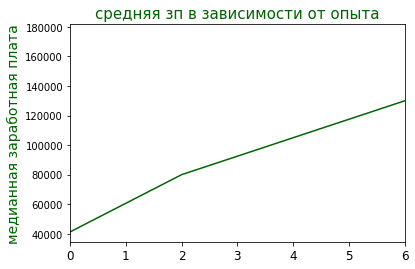

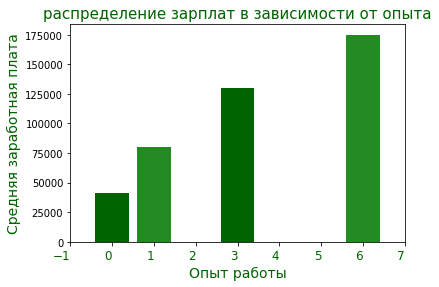

In [63]:
#@title
groups = ds.groupby('experience')
groups_sl = groups['salary']
groups_me = groups_sl.median().astype(int)
plt.plot(groups_me.index*2, groups_me.values, color='darkgreen')
plt.xlim(0,6)
plt.ylabel('медианная заработная плата', color='darkgreen')
plt.title('средняя зп в зависимости от опыта', color='darkgreen')
plt.show()
groups_me = groups_sl.median().astype(int)
plt.title('распределение зарплат в зависимости от опыта', color='darkgreen')
plt.ylabel('Средняя заработная плата', color='darkgreen')
plt.xlabel('Опыт работы', color='darkgreen')
plt.xlim(-1, 7)
plt.xticks(rotation=0,ha = 'right', color='darkgreen')
plt.bar(groups_me.index, groups_me, color=['darkgreen', 'forestgreen'])

plt.show()